In [1]:
%matplotlib inline
%load_ext lab_black

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from shared import (
    PickleableKerasRegressor,
    model_fun,
    reload_model,
    processing_data,
    compute_metrics,
)
from plot import (
    pred_plot,
    err_plot,
    error_per_month_and_site,
    error_per_month_and_year,
    plot_densities,
    plot_errors,
    plot_metrics,
    plot_timeline,
    model_list,
    models_and_true,
    transformed_features_and_gpp_histograms,
    characteristic,
    predict_all,
    plot_desity_and_errors,
)
from scipy import stats


resources = "resources/"
metadata_path = os.path.join(resources, "fdk_site_info.csv")
results_path = os.path.join(resources, "results.csv")
pred_path = os.path.join(resources, "predictions.csv.gz")
data_path = os.path.join(resources, "full_time_series.csv.gz")
gra_path = os.path.join(resources, "GRA.csv.gz")
dbf_path = os.path.join(resources, "DBF.csv.gz")

# Model evaluation

We start by loading the test set (unseen data):

In [2]:
df_pred = pd.read_csv(pred_path)
df_pred["date"] = pd.to_datetime(df_pred["date"])
df_pred.set_index(["site", "date"], inplace=True)
df_err = df_pred.sub(df_pred["True GPP"], axis=0)
df_pred

True GPP  baseline  ridge_2p_rs  knn_2p_pca  ridge_full  \
site   date                                                                  
CA-Qfo 2006-07-29  5.954355  3.721324     5.431386    7.825136    4.889608   
SE-Nor 2018-12-26  0.311561  3.721324     2.133815    0.043292    0.197568   
US-GLE 2010-01-19 -0.063079  3.721324     0.127532    0.066736    0.139643   
CA-Ca1 1998-03-25  5.951341  3.721324     5.078316    3.031969    4.992864   
US-NR1 2002-01-30 -0.095750  3.721324     1.061053    0.076665    0.232143   
...                     ...       ...          ...         ...         ...   
IT-Tor 2014-07-17  9.215022  3.721324     7.236303    7.031351    9.732504   
CA-TP1 2015-01-27 -0.058313  3.721324     0.182209    0.048850    0.068563   
FI-Sod 2012-11-21  0.008724  3.721324     0.916572    0.017935    0.021110   
US-BZS 2017-07-04  7.621615  3.721324     5.066162    8.744079    7.455506   
DE-Tha 2002-03-22  2.595536  3.721324     3.051069    2.434386    2.121158   

                    rf_full  svr_full  dnn_full  
site   date                                      
CA-Qfo 2006-07-29  5.379987  5.764638  5.109420  
SE-Nor 2018-12-26  0.100228  0.134585  0.145641  
US-GLE 2010-01-19  0.033815  0.021267  0.005853  
CA-Ca1 1998-03-25  6.324372  6.022709  6.558621  
US-NR1 2002-01-30 -0.024778 -0.045559 -0.048444  
...                     ...       ...       ...  
IT-Tor 2014-07-17  9.075902  8.667749  7.649843  
CA-TP1 2015-01-27 -0.002462 -0.016403  0.000343  
FI-Sod 2012-11-21  0.014940  0.016052  0.041832  
US-BZS 2017-07-04  6.819909  6.758012  6.758407  
DE-Tha 2002-03-22  2.689673  2.297708  2.352741  

[49599 rows x 8 columns]

## Individual model evaluation

### Simple models

#### ridge_2p_rs

This model was a 2-parameter linear regression using remote sensed data.
Even though this is not the best performing model, it displays some features which are shared by all the other models.
We will therefore analyze this model in depth, and further models will be described more succinctly.

##### Error characterization

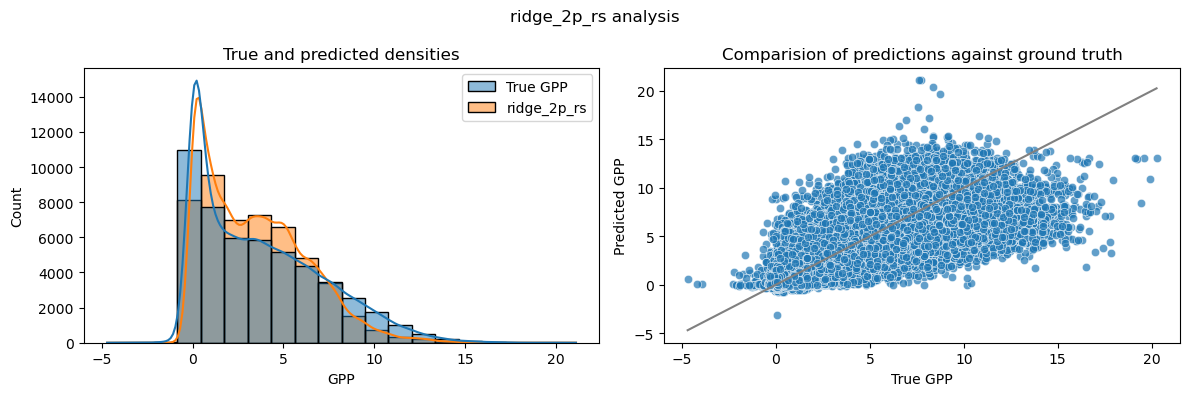

In [3]:
pred_plot(df_pred, "ridge_2p_rs")

- The histogram above shows that the distribution of predicted GPP values does not match the true GPP distribution well.
In particular, we observe a bulging of the middle range of the predicted histogram (orange) not present in the true histogram (blue).
- The scatter plot shows that the model overestimates low GPP values, and underestimate high GPP values (switch).
Unfortunately, this characteristic will affect all our models.

Looking at the histogram of the errors below, we observe an unskewed distribution, but, as stated above, the scatter plot of the error against the true GPP shows a clear switch.

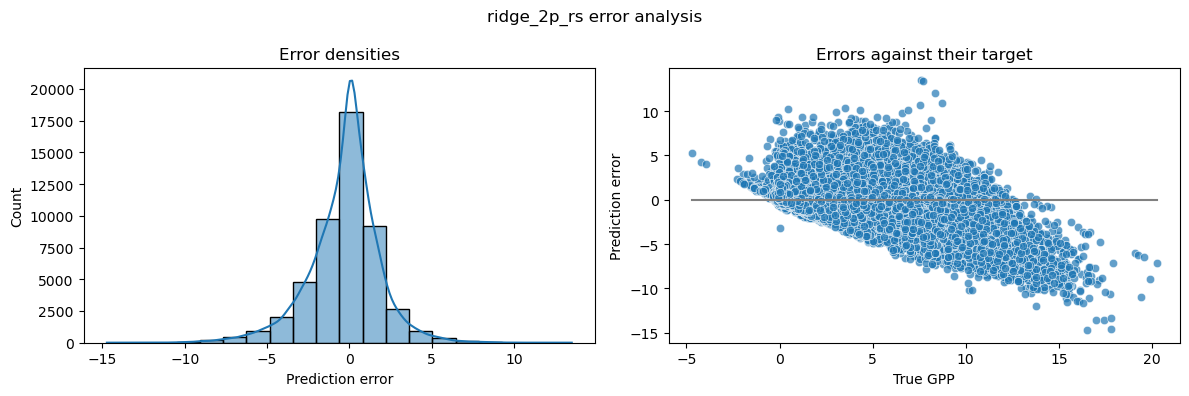

In [4]:
err_plot(df_pred, df_err, "ridge_2p_rs")

It may seem like the model did not minimize the residual error at all, but if we display a smaller portion of the data, 
we can see that the reason is that the vast majority of the data points is located around zero and the tail to the right is very light compared to the bulk of the data around zero:

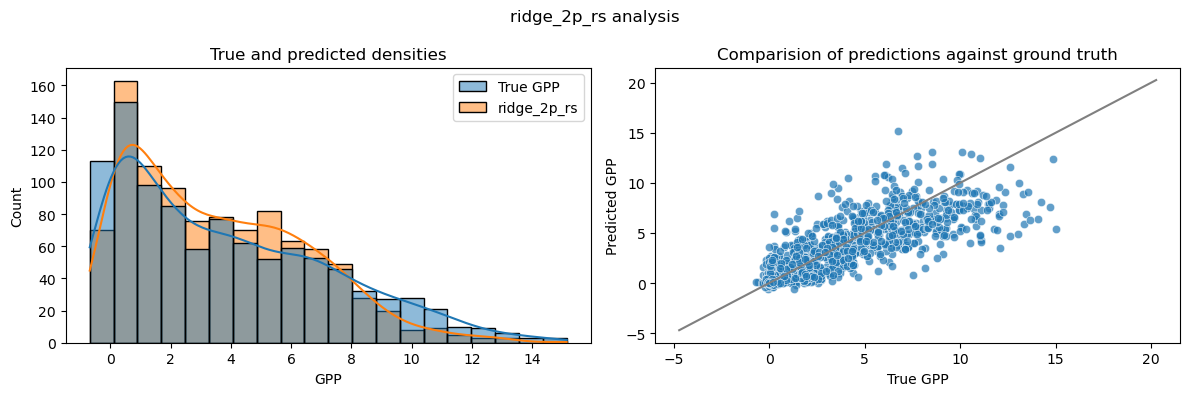

In [5]:
pred_plot(df_pred, "ridge_2p_rs", 0.02)

In other words, the model considers high GPP values as outliers and regularization prevents from learning them.
Regularization is needed though because of the noise present in the data in general.
This problem might have been exacerbated by the use of the quantile transform which is highly non-linear in our case (since our distributions are so biased).
As an example, the characteristic of the scaler fitted on GPP is shown below:

C:\Users\mayeu\miniconda3\envs\adsml\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but QuantileTransformer was fitted without feature names
  warnings.warn(


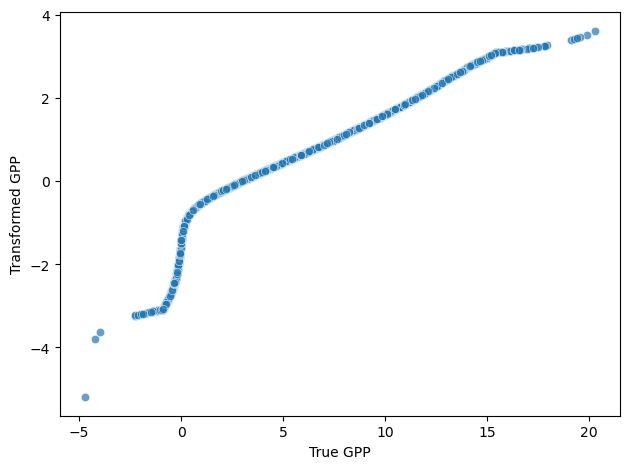

In [6]:
model = reload_model("ridge_2p_rs")
characteristic(model, df_pred["True GPP"])

We can see that the transformation magnifies values around 0. Doing so also magnifies the noise.
Hence my hypothesis is that this extra noise requires high levels of regularization, which in turn prevents the model from learning from the high GPP values, which are low in number and therefore considered by the model as outliers.

The use of other scalers (none, standard, robust) was attempted but the result was the same.
Using MSE as criterion for the choice of the best estimator in the grid search also did not improve the fit.

##### Seasonal and site generalization

Let us now look at the average error per month and sites:

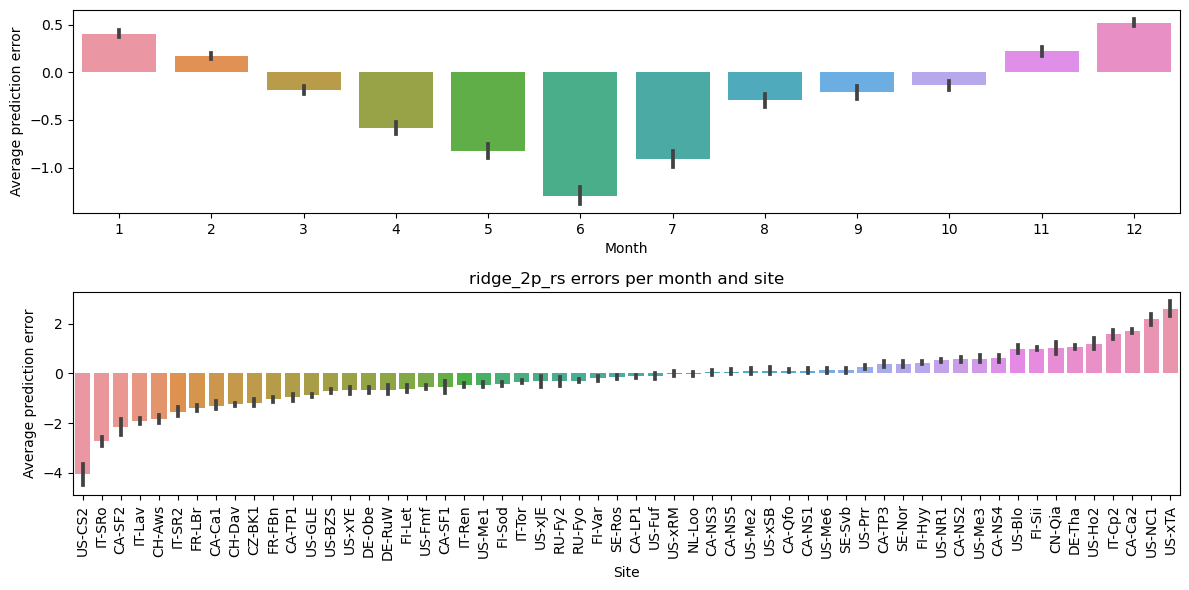

In [7]:
error_per_month_and_site(df_err, "ridge_2p_rs")

We find that the model overestimates GPP in the winter months (where GPP is low) and underestimates in summer (where GPP is high). This is the switch we have observed before.
Both the average and variance errors in summer (high GPP) are also much more pronounced than in winter (low GPP).

There is a lot of variation in the average error per site, indicating that our model generalizes poorly across sites.
Looking at the GPP densities on extreme sites (`US-CS2` and `CA-Ca2`) gives some indication of why the model struggles with these:

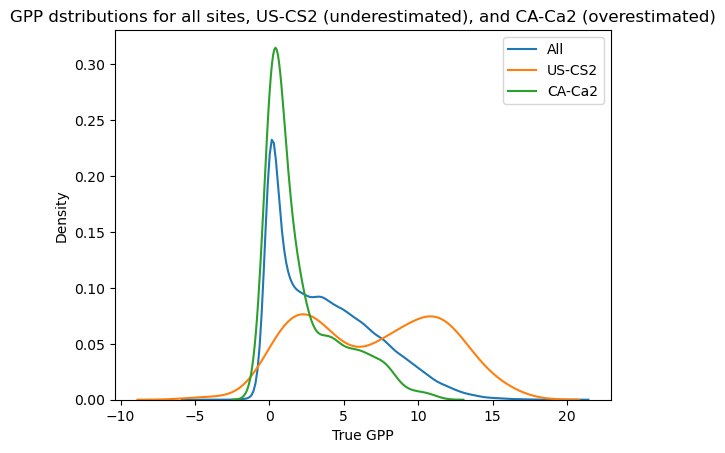

In [8]:
all_sites = df_pred["True GPP"]
us = all_sites.loc["US-CS2"]
ca = all_sites.loc["CA-Ca2"]
sns.kdeplot(all_sites, label="All")
sns.kdeplot(all_sites.loc["US-CS2"], label="US-CS2")
sns.kdeplot(all_sites.loc["CA-Ca2"], label="CA-Ca2")
plt.title(
    "GPP dstributions for all sites, US-CS2 (underestimated), and CA-Ca2 (overestimated)"
)
plt.legend()
plt.show()

The GPP density for US-CS2 (in orange) is not similar to the average density of all the sites (in blue): it is more spread and contains considerably more high GPP values than the average (in blue).
Since we have already seen that the model underestimates high GPP values, it explains the negative average error for this site.
Conversely, the site CA-Ca2 (in green) has a GPP density which looks more alike the average one, but with even less medium and high GPP values, and more low GPP values.
It is therefore overestimated.

#### knn_2p_pca

This model was a 2-dimension kNN regression using local variables only.
The two dimensions were obtained from a PCA projection.

The observations are very similar to those of the previous model, so we do not repeat them.

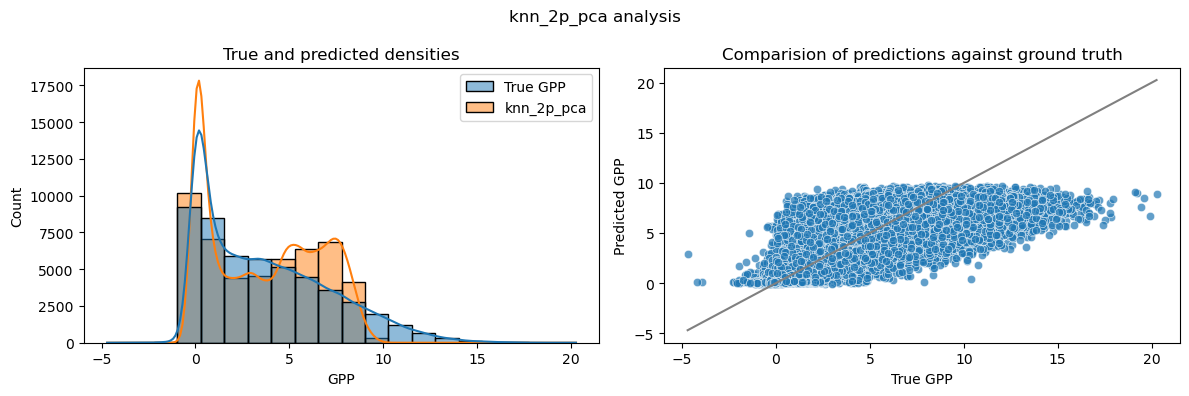

In [9]:
pred_plot(df_pred, "knn_2p_pca")

It is interesting to note that the model seems to have capped the predicted values to 10.

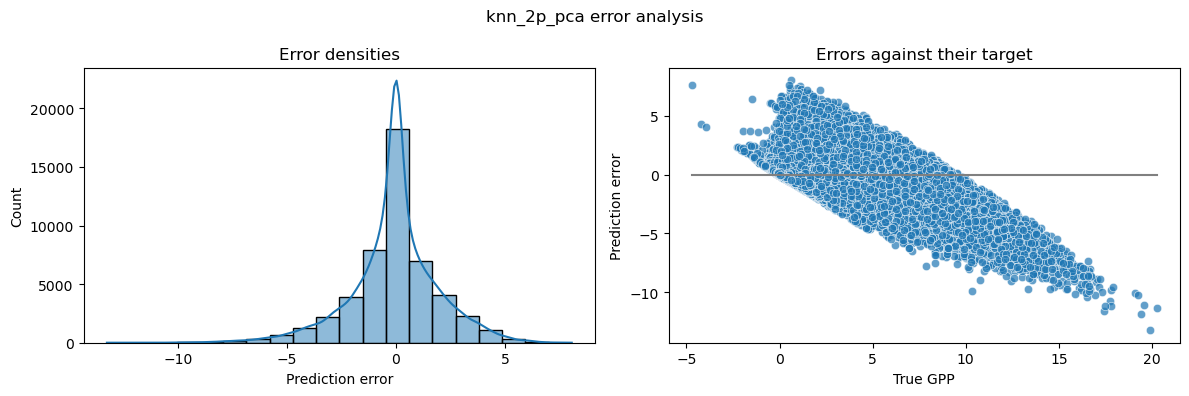

In [10]:
err_plot(df_pred, df_err, "knn_2p_pca")

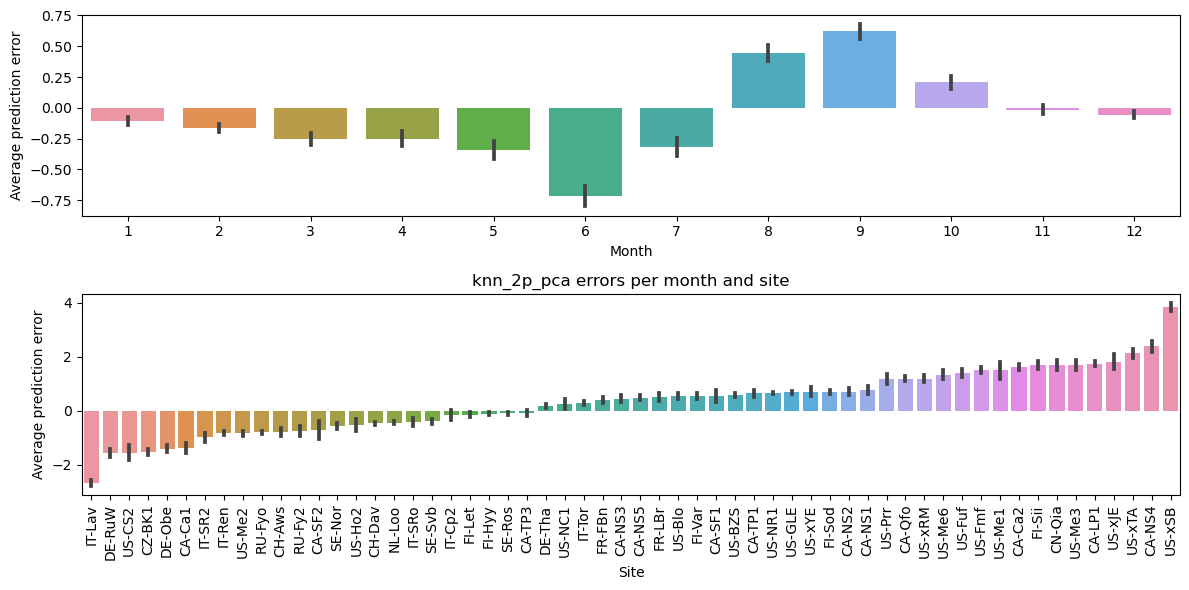

In [11]:
error_per_month_and_site(df_err, "knn_2p_pca")

### Full models

#### ridge_full

This model was a linear regression using all the variables.

The distribution of the predicted values fits quite well to the true distribution, compared to the previous models.
The predicted values are also much closer to the true GPP values.

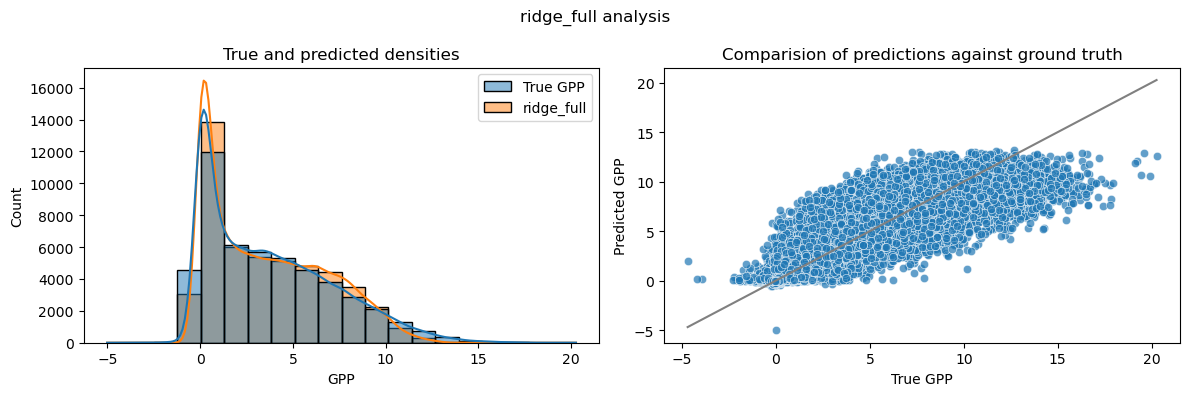

In [12]:
pred_plot(df_pred, "ridge_full")

The errors are still unskewed, but the scatter plot of the errors below still shows a clear switch although the errors are generally smaller than in the previous models.

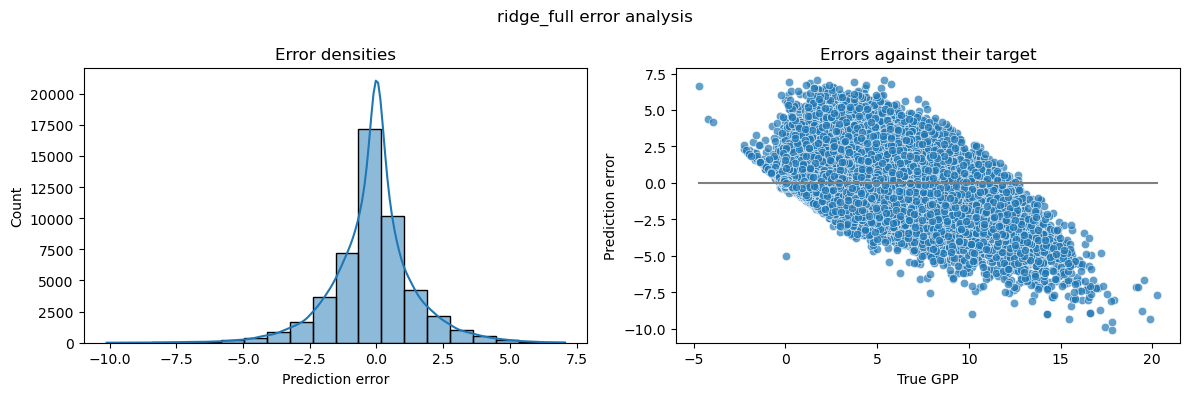

In [13]:
err_plot(df_pred, df_err, "ridge_full")

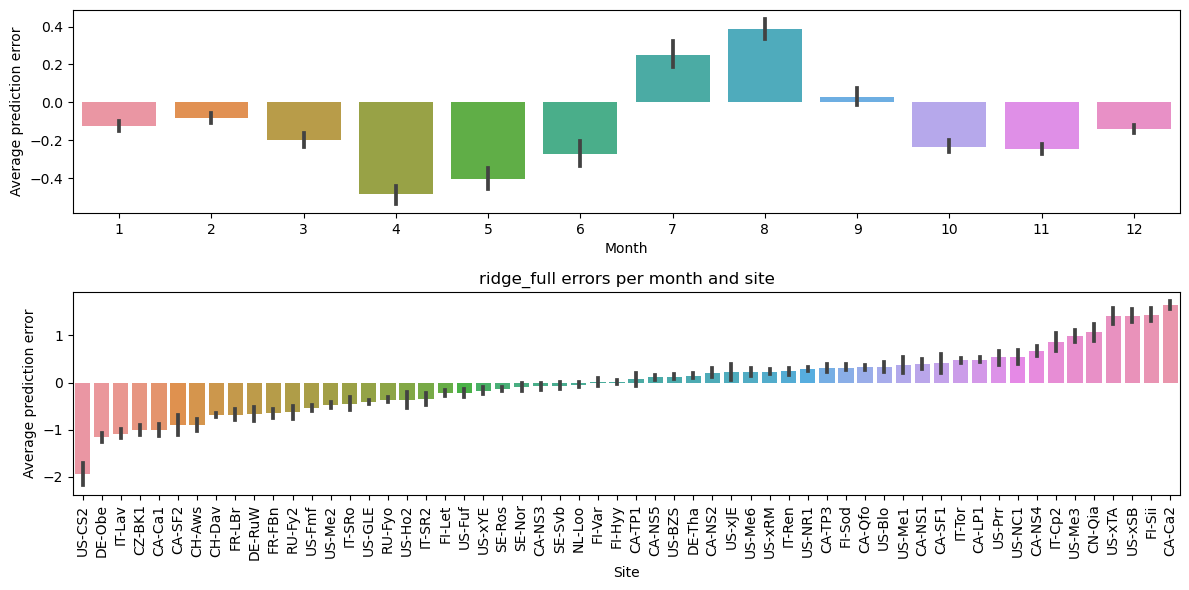

In [14]:
error_per_month_and_site(df_err, "ridge_full")

We also note that it is roughly the same sites that occupy both ends of the bar chart for all the models so far.

#### rf_full

This model was a random forest regression using all the variables.

The switch is still present and this time the error is very slightly biased towards negative values.

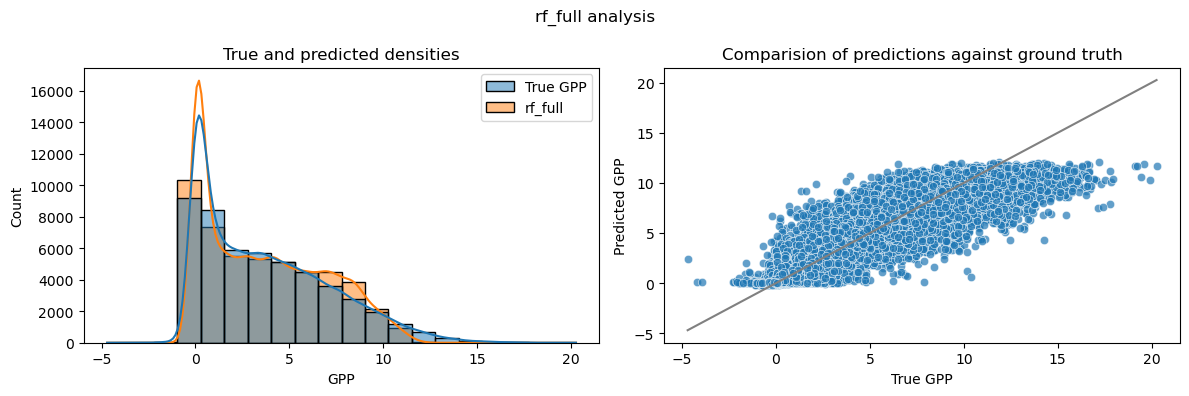

In [15]:
pred_plot(df_pred, "rf_full")

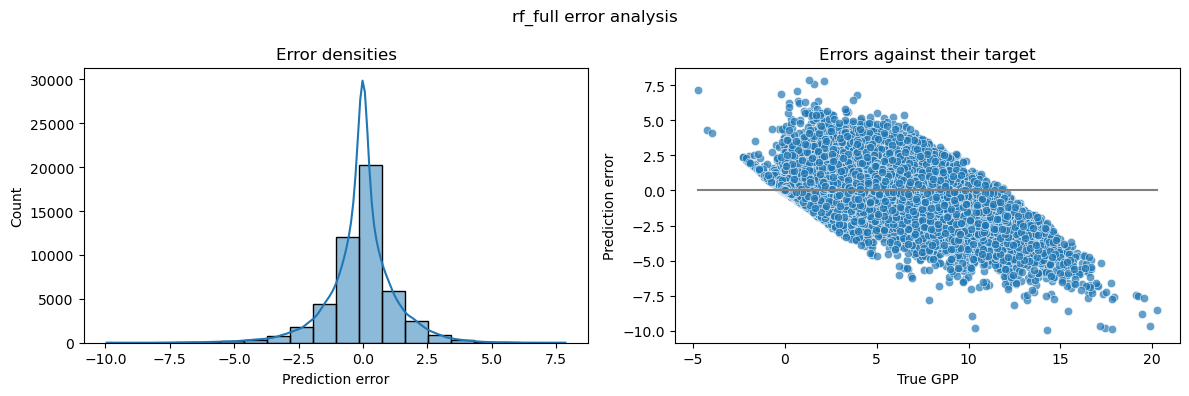

In [16]:
err_plot(df_pred, df_err, "rf_full")

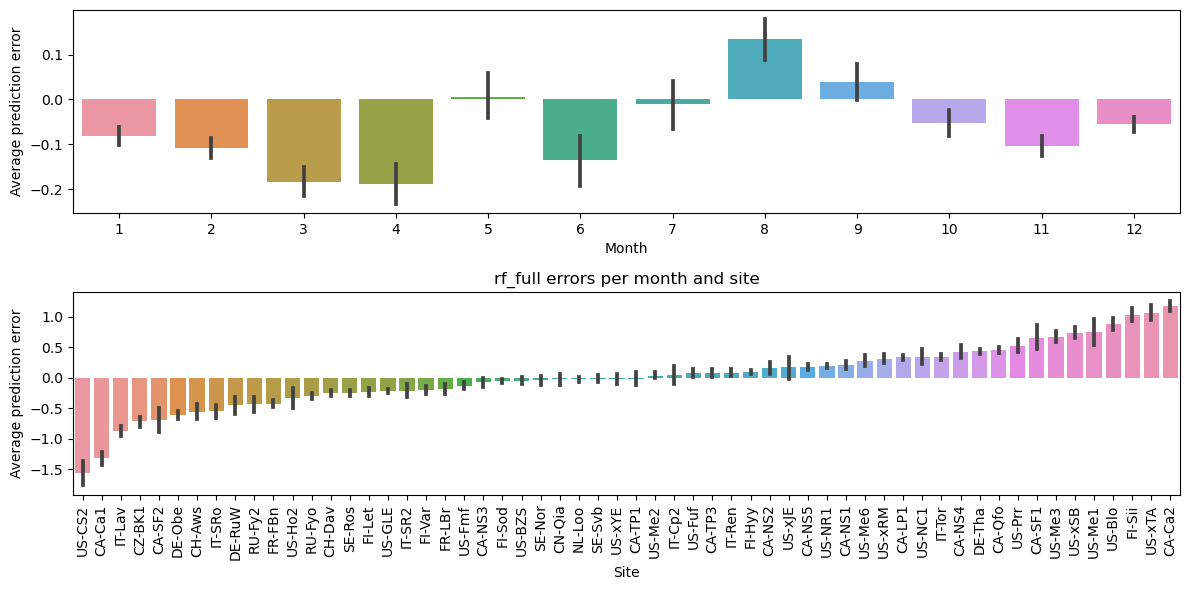

In [17]:
error_per_month_and_site(df_err, "rf_full")

#### svr_full

This model was a SVR regression using all the variables.

Same comments as above.

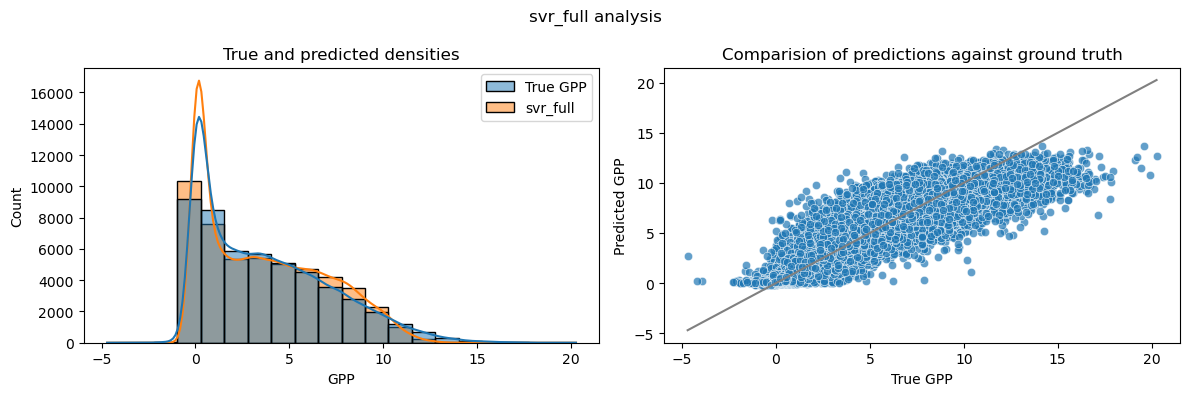

In [18]:
pred_plot(df_pred, "svr_full")

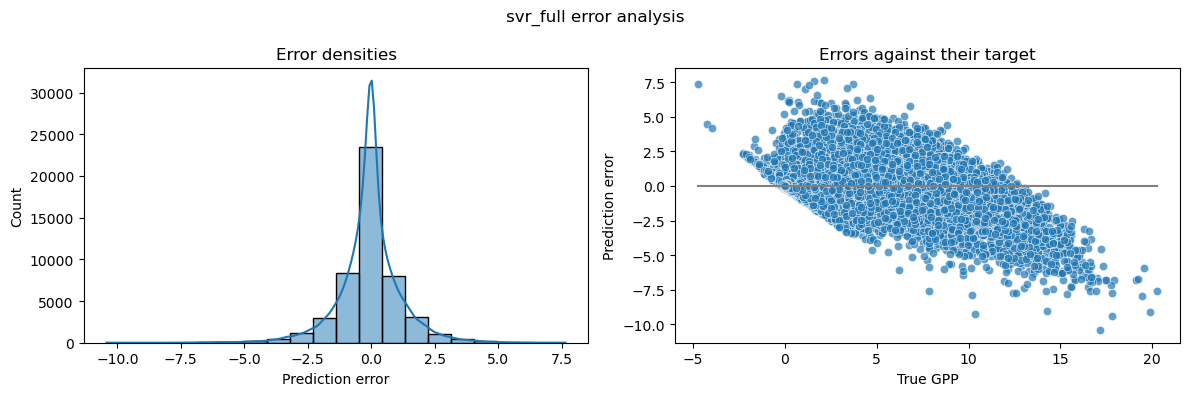

In [19]:
err_plot(df_pred, df_err, "svr_full")

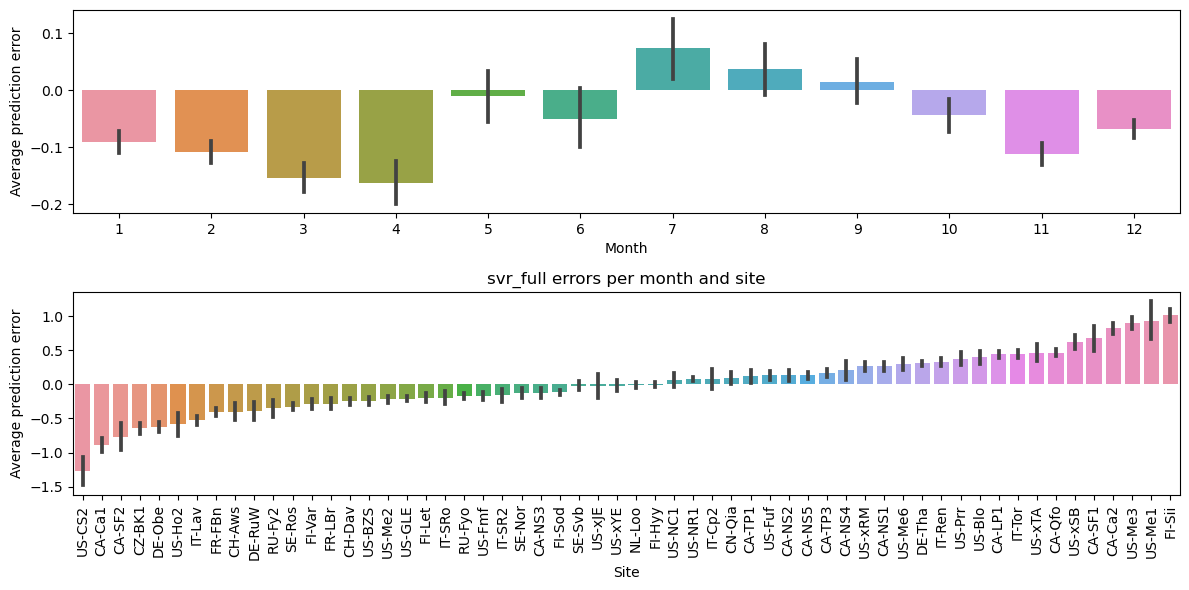

In [20]:
error_per_month_and_site(df_err, "svr_full")

#### dnn_full

This model was a 2-layer DNN using all the variables.

Same comments as above, but we note that this model underestimates quite systematically.

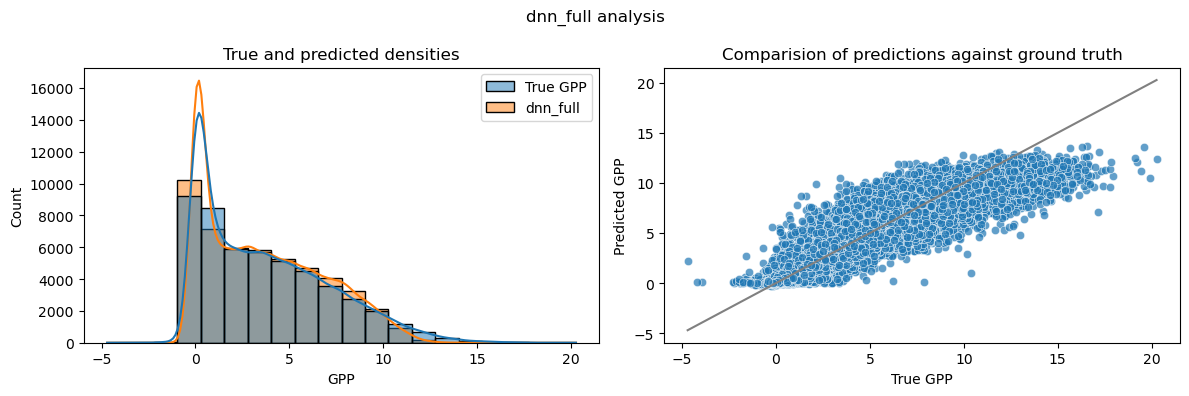

In [21]:
pred_plot(df_pred, "dnn_full")

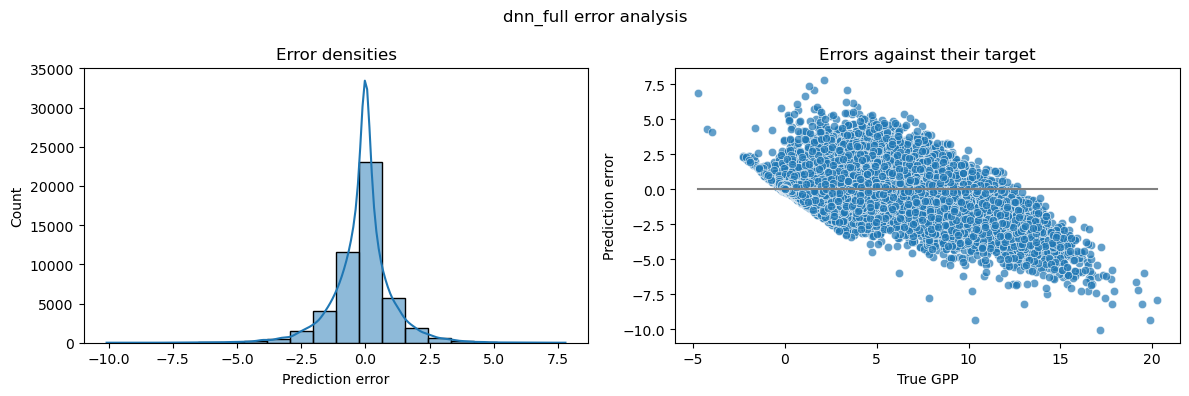

In [22]:
err_plot(df_pred, df_err, "dnn_full")

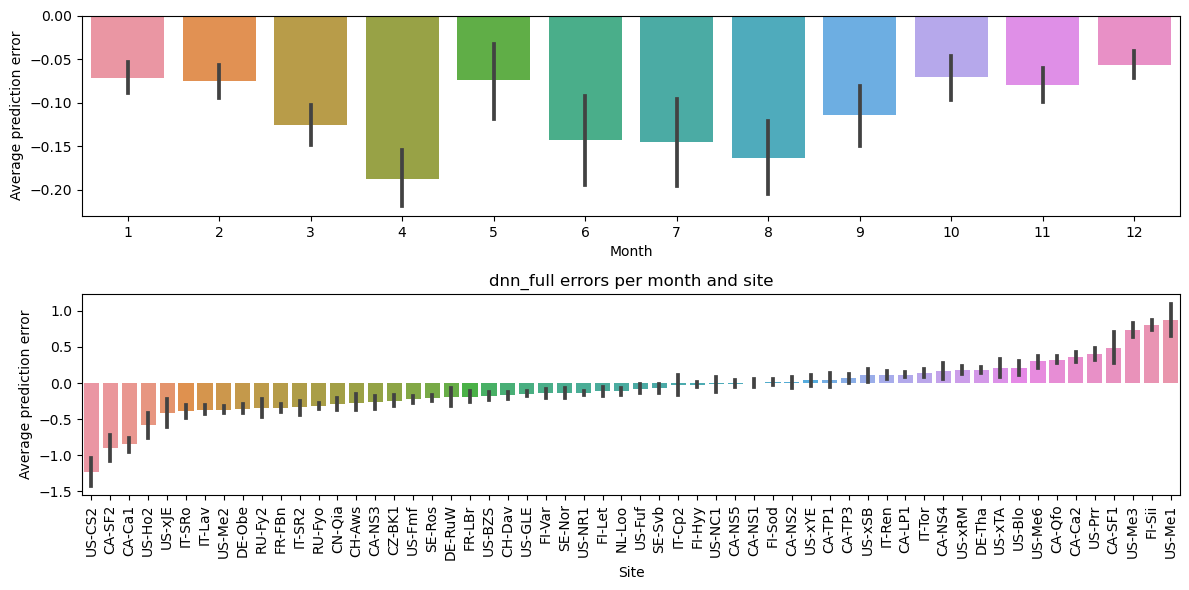

In [23]:
error_per_month_and_site(df_err, "dnn_full")

While other models tended to underestimate and overestimate as many sites, this model underestimates most.

## Models comparison

We can see that no model achieves a straight line when plotted against true GPP, but the SVR (`svr_full`) and DNN (`dnn_full`) are maybe the ones that come the closest to it.
In addition, those two models seem very well correlated, indicating that they learned the same patterns(?).

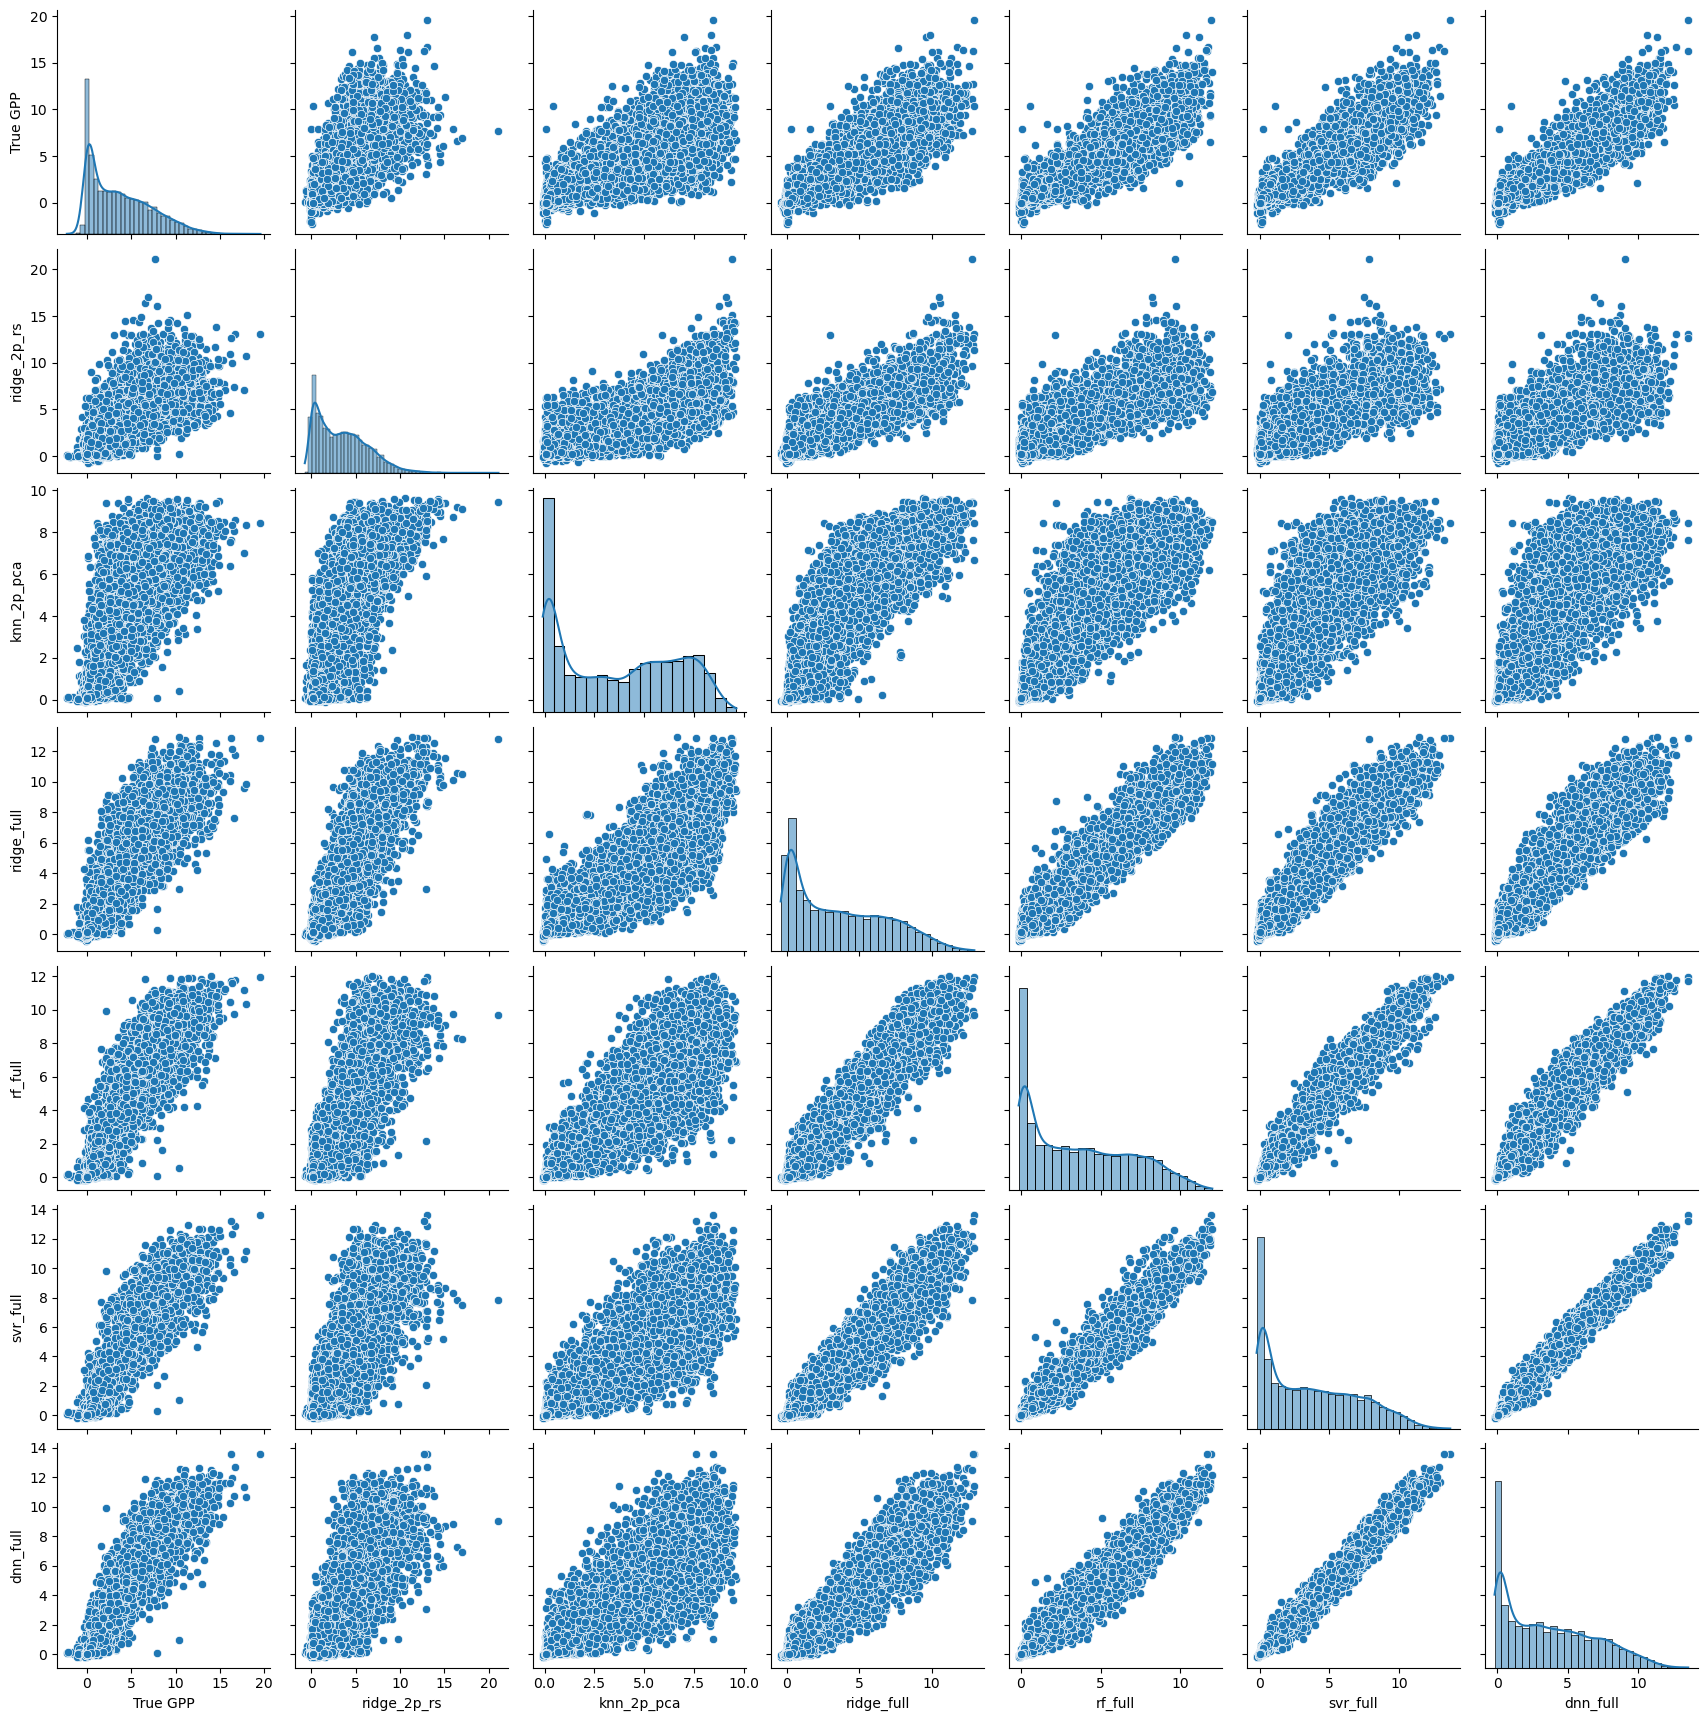

In [24]:
sns.pairplot(
    df_pred[["True GPP"] + model_list[1:]].sample(10000),
    diag_kws={"kde": True},
)
plt.show()

Comparing the densities below, all the models, except the two 2-parameter models `ridge_2p_rs` and `knn_2p_pca`, present a shape that fits fairly well true density.

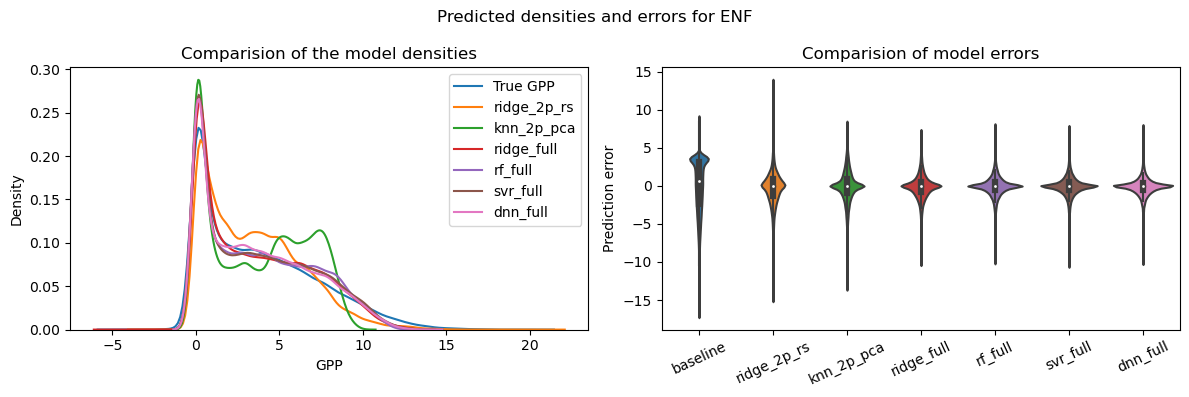

In [25]:
plot_desity_and_errors(df_pred, df_err, cover_type="ENF")

Looking at the error densities, it is difficult to see any major difference between the four "full" models, indicating that they most likely perform similarly.

### Model ranking

Let us compare the metrics for each model:

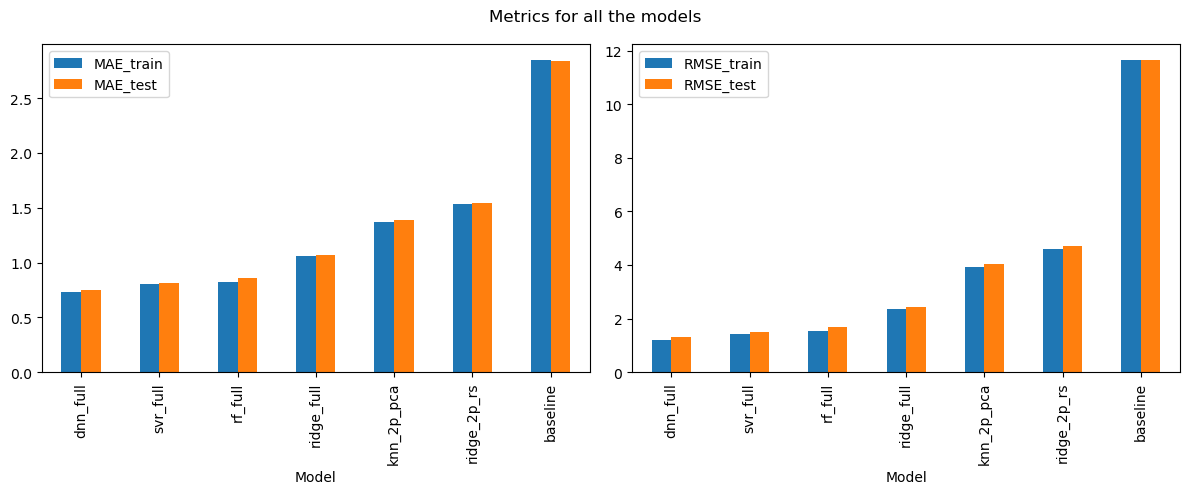

In [26]:
results_df = pd.read_csv(results_path).set_index("model")
plot_metrics(results_df, ["train", "test"])

The fact that the metrics for both train and test sets are very close to each other indicates that the models did not overfit.
For both MAE and RMSE, the DNN model (`dnn_full`) is the winner.

On a side note, the models have widely different predicting times.
In particular, SVR is astonishingly slow!

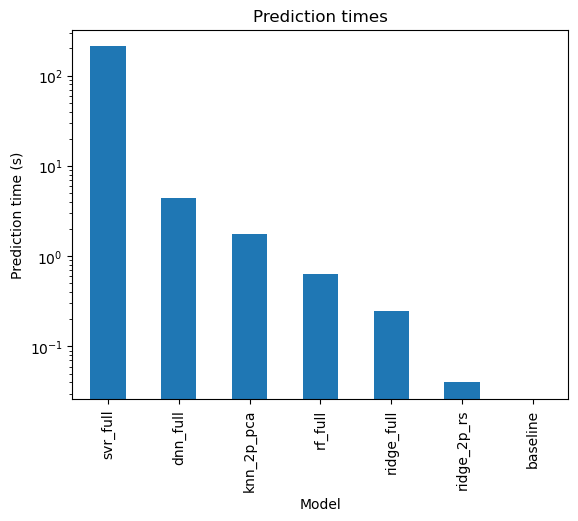

In [27]:
results_df["pred_time_test"].sort_values(ascending=False).plot.bar()
plt.xlabel("Model")
plt.ylabel("Prediction time (s)")
plt.yscale("log")
plt.title("Prediction times")
plt.show()

## Whole time series predictions

We now turn ourselves towards full time series from three land cover type:
- Evergreen Needleaf Forest (ENF), which was the type we studied in this assignment,
- Desiduous Broadleaf Forest (DBF),
- Grassland (GRA).

The aim is to see if our best model is capable of predicting whole time series, and if it generalizes well to other vegetation types.

### Loading and processing the data

Let us start by loading the data and processing it in the same way we processed our data during the EDA.

#### ENF

Loading the data
Loading metadata and joining
Adding GPP and GPP_diff
Dropping unused features
Removing bad values
Adding rolling window features
Processing P_F_1w...
Processing P_F_4w...
Processing TA_F_MDS_1w...
Processing TA_F_MDS_4w...
Processing VPD_F_MDS_1w...
Processing VPD_F_MDS_4w...
Adding engineered features
Remove unused features
NA: 61


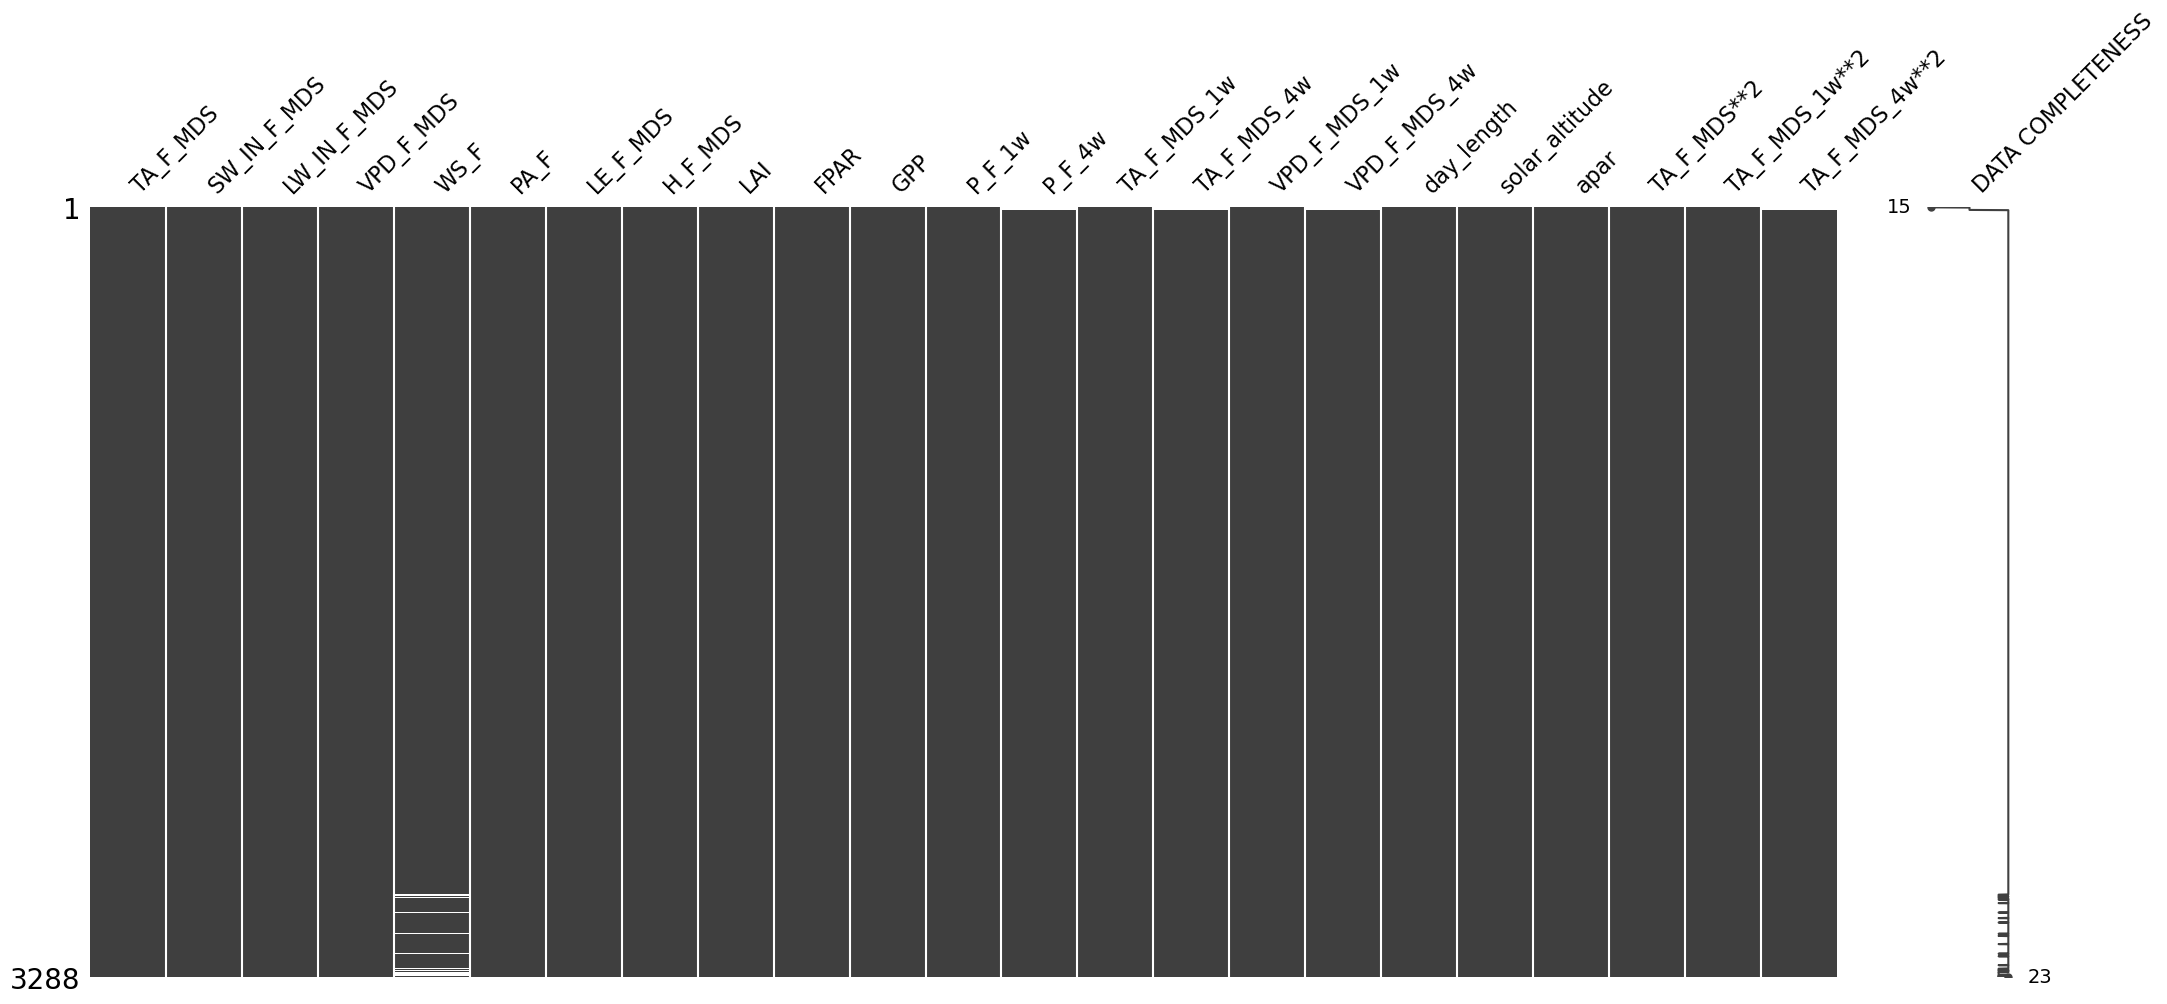

In [28]:
# This function performs neither outlier detection nor scaling so there should be no data leakage.
df = processing_data(data_path, metadata_path)

There are some wind speed values missing. We fill them with the mean value, then drop the few samples still containing null values:

In [29]:
df["WS_F"].fillna(df["WS_F"].mean(), inplace=True)
df.dropna(inplace=True)
len(df)

3275

We now create the feature matrix and target vector:

In [30]:
X_enf = df.drop(["GPP"], axis=1)
y_enf = df[["GPP"]]

Finally, we load all the models and compute the predictions:

In [31]:
df_pred_enf, df_err_enf, stats = predict_all(X_enf, y_enf, "ENF")
results_df = results_df.join(stats)

Predicting baseline...
Predicting ridge_2p_rs...
Predicting knn_2p_pca...
Predicting ridge_full...
Predicting rf_full...
Predicting svr_full...
Predicting dnn_full...
205/205 [==============================] - 1s 2ms/step


#### DBF

We proceed with the same steps for the DBF time series:

Loading the data
Loading metadata and joining
Adding GPP and GPP_diff
Dropping unused features
Removing bad values
Adding rolling window features
Processing P_F_1w...
Processing P_F_4w...
Processing TA_F_MDS_1w...
Processing TA_F_MDS_4w...
Processing VPD_F_MDS_1w...
Processing VPD_F_MDS_4w...
Adding engineered features
Remove unused features
NA: 134


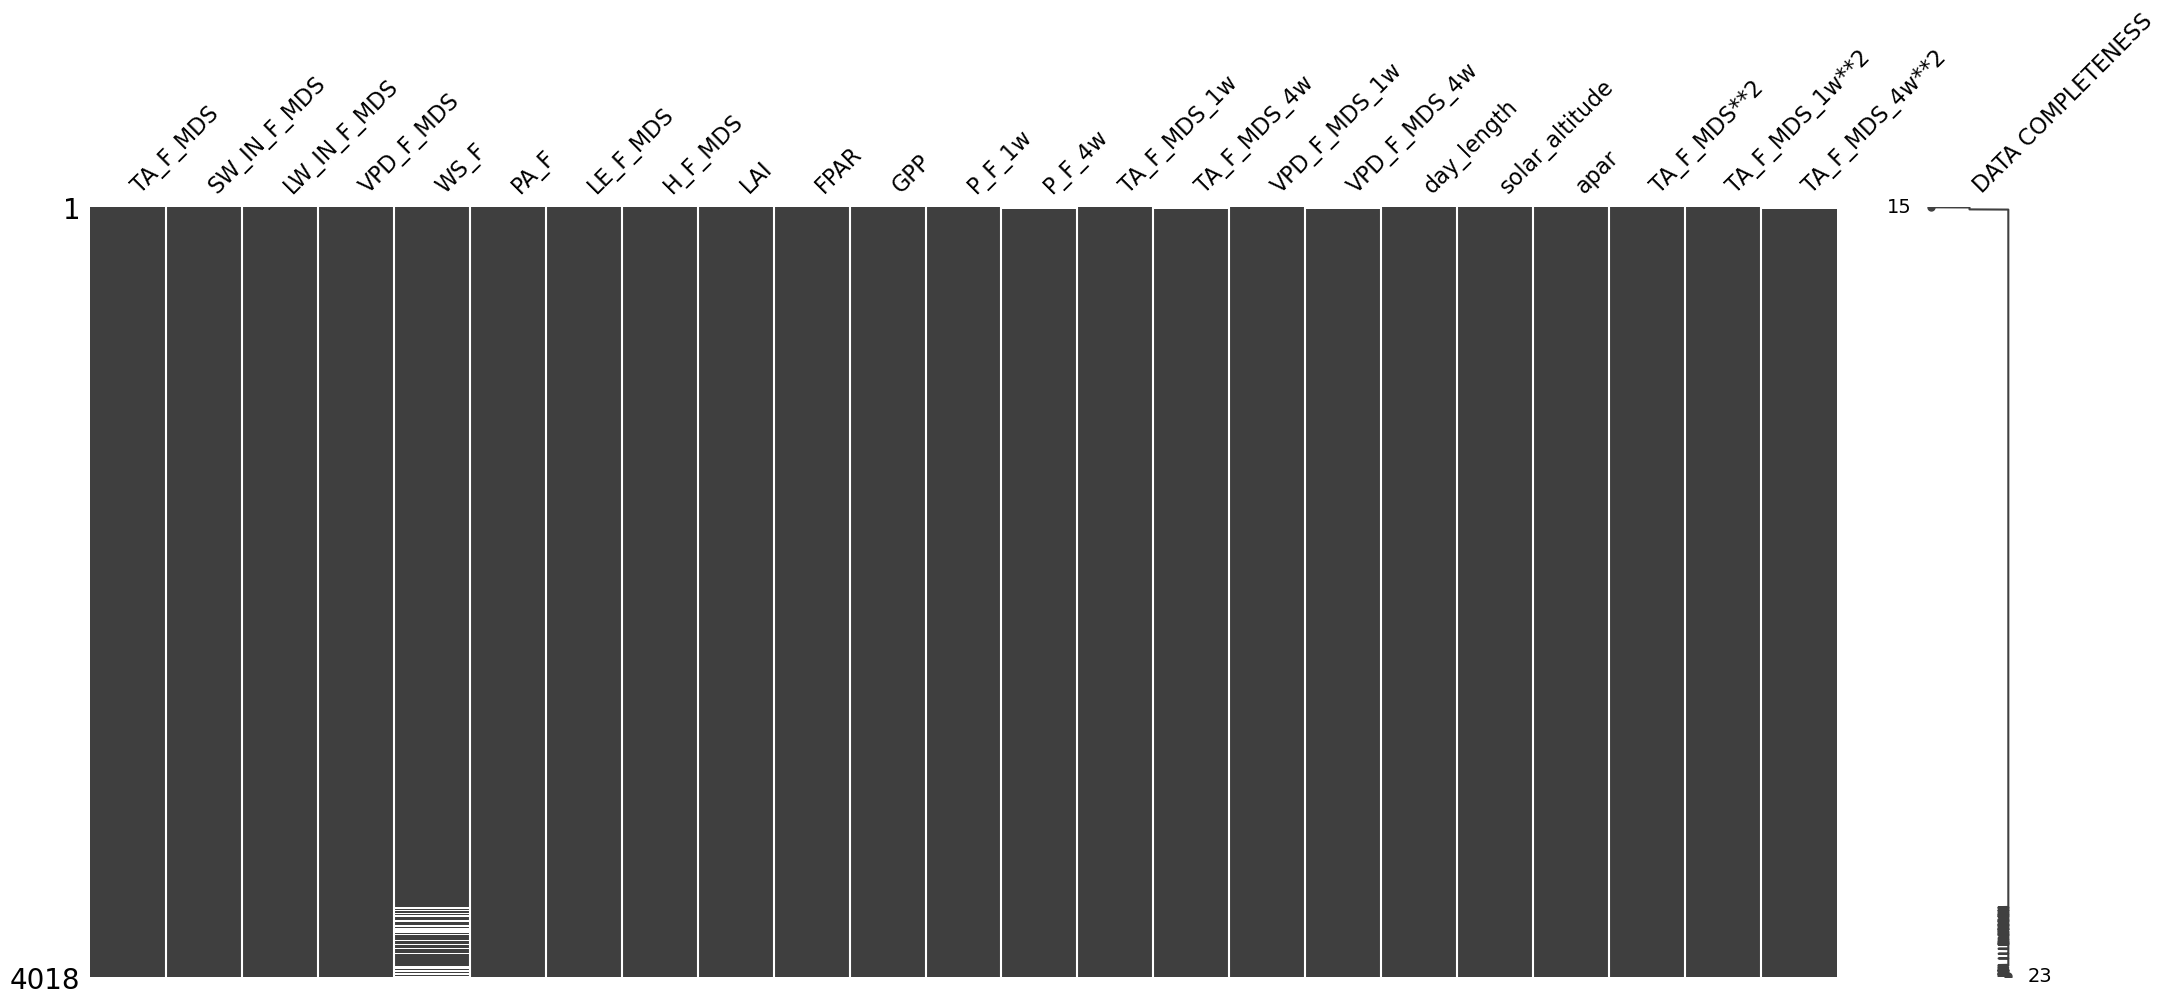

In [32]:
df = processing_data(dbf_path, metadata_path)

In [33]:
df["WS_F"].fillna(df["WS_F"].mean(), inplace=True)
df.dropna(inplace=True)
X_dbf = df.drop(["GPP"], axis=1)
y_dbf = df[["GPP"]]
len(y_dbf)

4005

In [34]:
df_pred_dbf, df_err_dbf, stats = predict_all(X_dbf, y_dbf, "DBF")
results_df = results_df.join(stats)

Predicting baseline...
Predicting ridge_2p_rs...
Predicting knn_2p_pca...
Predicting ridge_full...
Predicting rf_full...
Predicting svr_full...
Predicting dnn_full...
251/251 [==============================] - 1s 3ms/step


#### GRA

We proceed with the same steps for the GRA time series:

Loading the data
Loading metadata and joining
Adding GPP and GPP_diff
Dropping unused features
Removing bad values
Adding rolling window features
Processing P_F_1w...
Processing P_F_4w...
Processing TA_F_MDS_1w...
Processing TA_F_MDS_4w...
Processing VPD_F_MDS_1w...
Processing VPD_F_MDS_4w...
Adding engineered features
Remove unused features
NA: 24


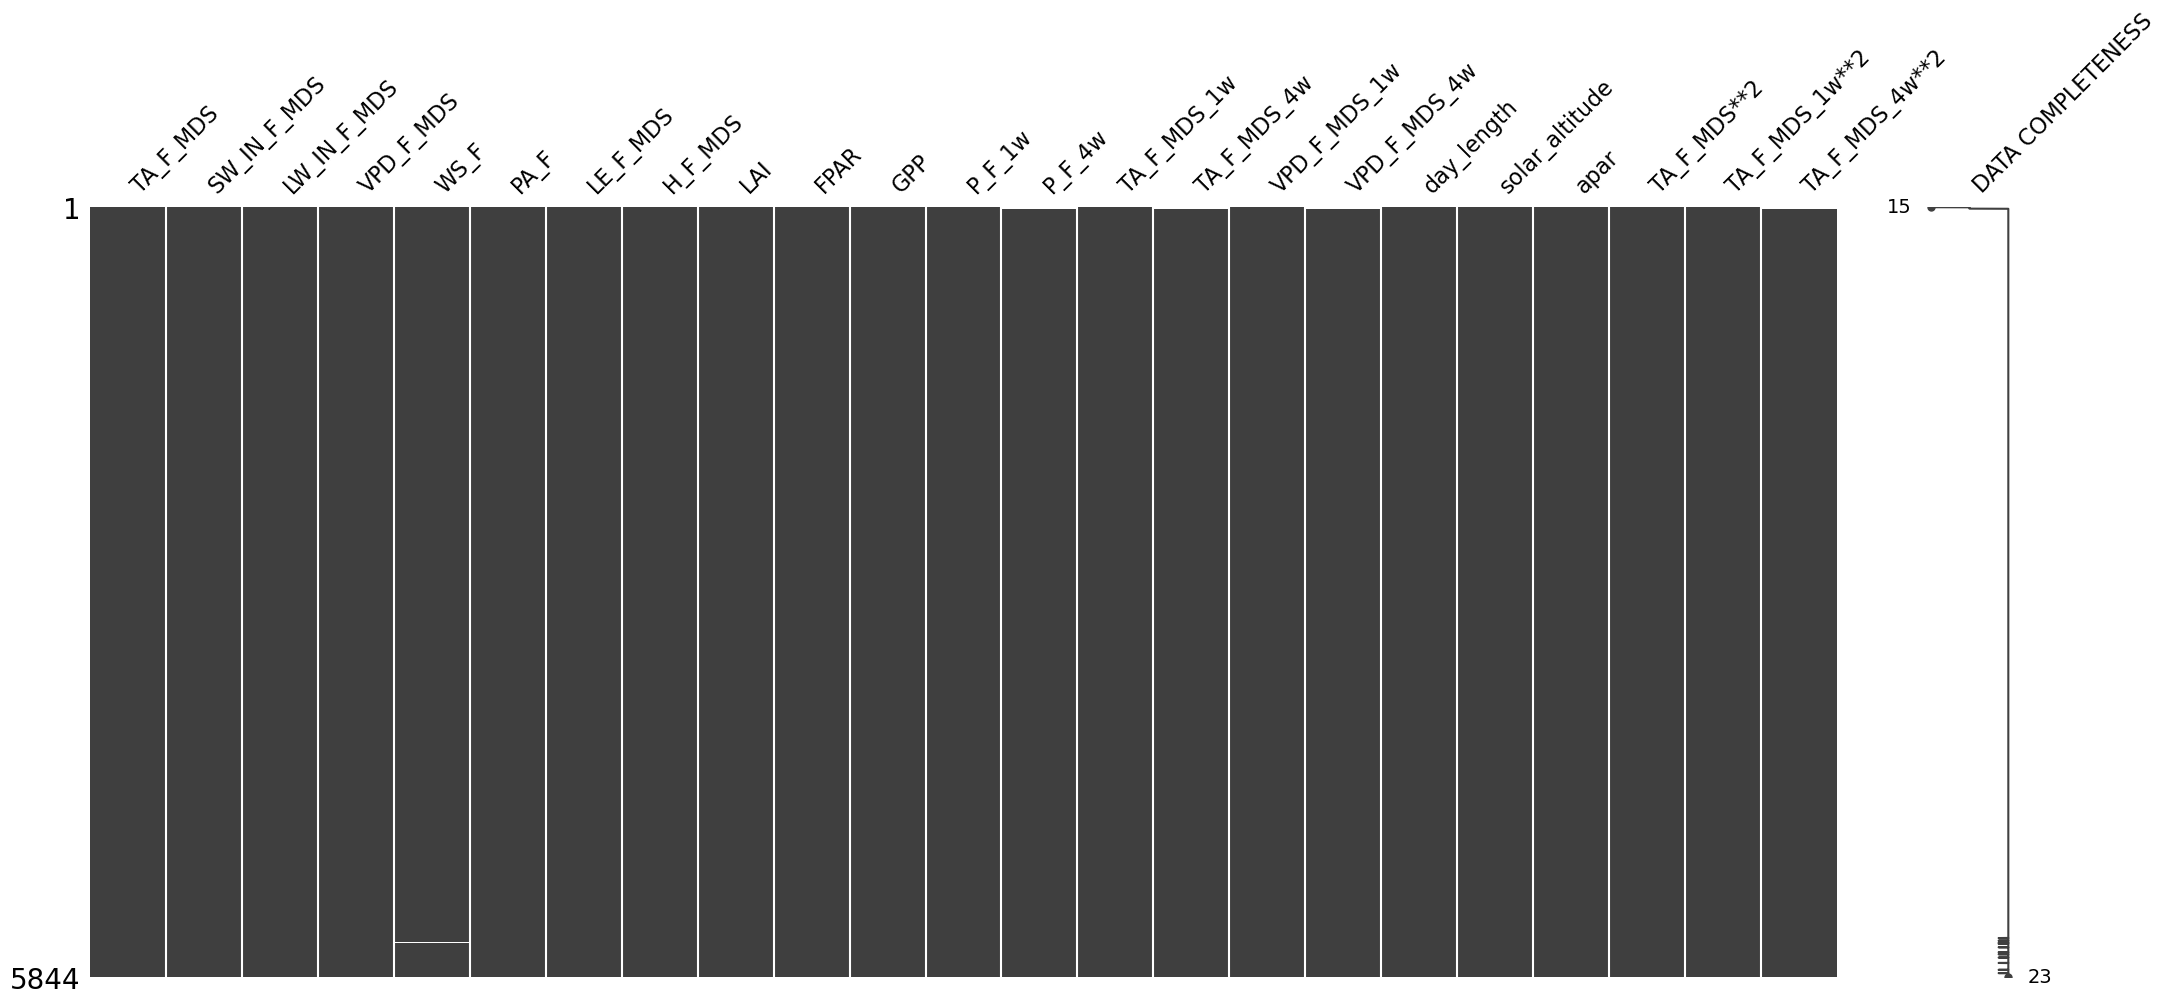

In [35]:
df = processing_data(gra_path, metadata_path)

In [36]:
df["WS_F"].fillna(df["WS_F"].mean(), inplace=True)
df.dropna(inplace=True)
X_gra = df.drop(["GPP"], axis=1)
y_gra = df[["GPP"]]
len(y_gra)

5830

In [37]:
df_pred_gra, df_err_gra, stats = predict_all(X_gra, y_gra, "GRA")
results_df = results_df.join(stats)

Predicting baseline...
Predicting ridge_2p_rs...
Predicting knn_2p_pca...
Predicting ridge_full...
Predicting rf_full...
Predicting svr_full...
Predicting dnn_full...
365/365 [==============================] - 1s 1ms/step


### Comparison

We start by comparing the scores of the different models for the three sites as well as the test set (as a reference point).
The models are sorted by the order of performance on the test set.

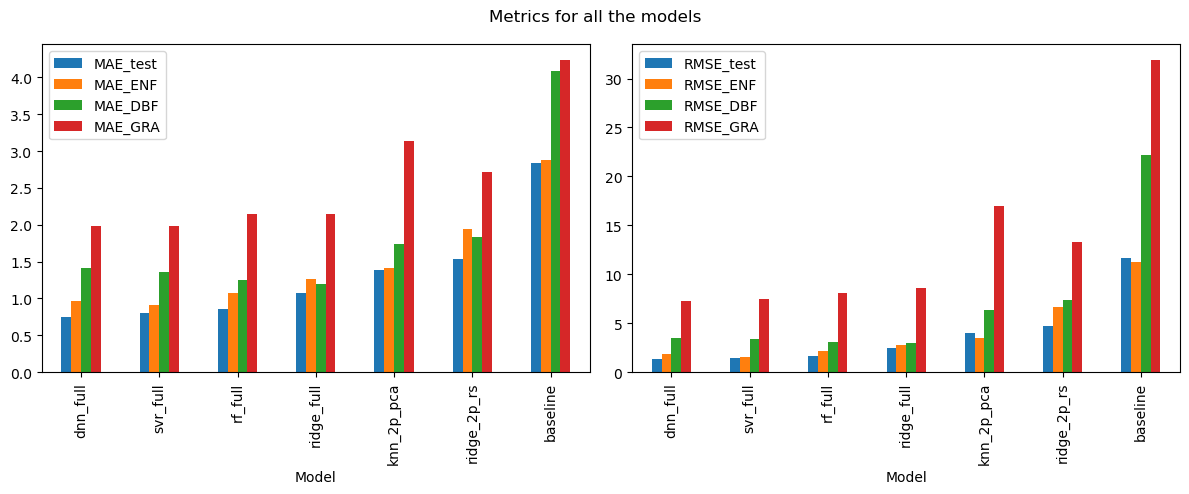

In [38]:
plot_metrics(results_df, ["test", "ENF", "DBF", "GRA"], "test")

We note that ENF is consistently the best predicted site, as expected since we trained the models using exclusively ENF sites, followed by DBF, and finally comes GRA with a much larger score.
It is difficult to declare a winner: the four complex models perform approximately similarly with the three land cover types.
SVR is the best performer on ENF, closely followed by DNN. The ridge regression is best on DBF, and is overall the most consistent across both ENF and DBF cover types.

Below are plotted the predicted error densities for the three sites.

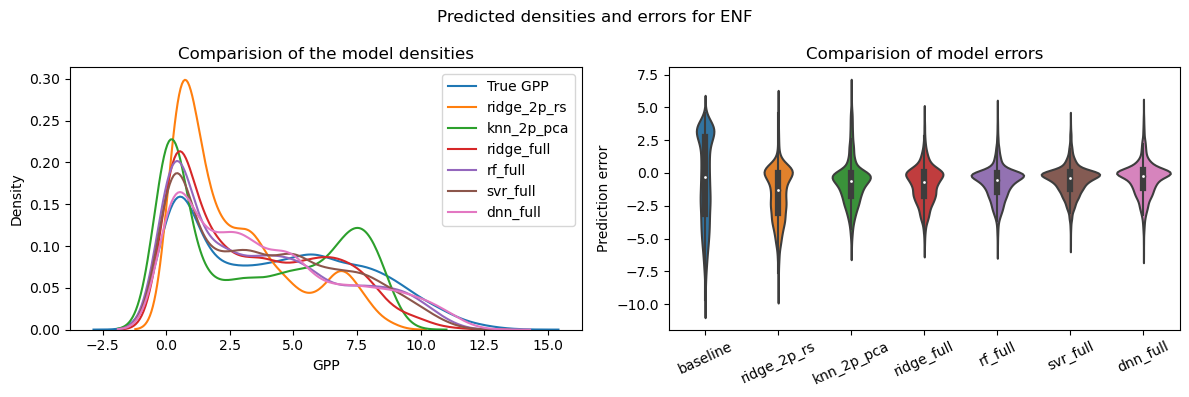

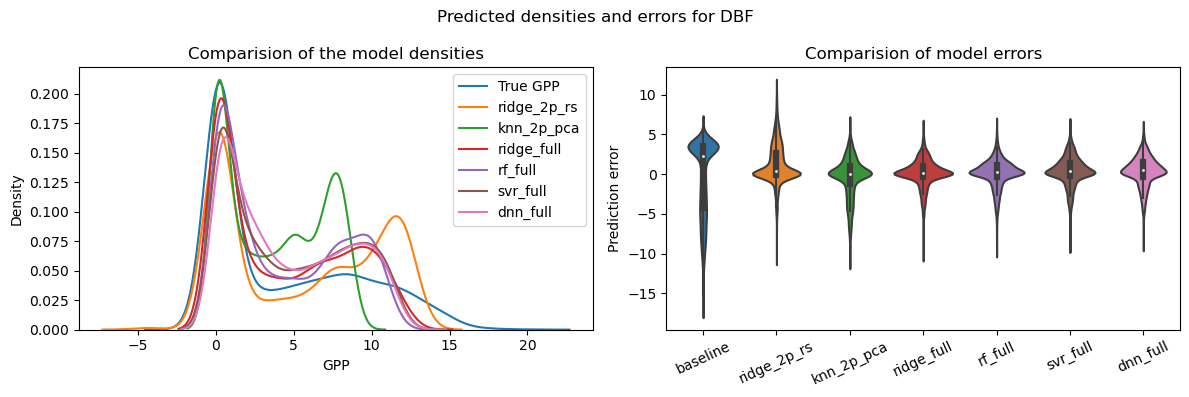

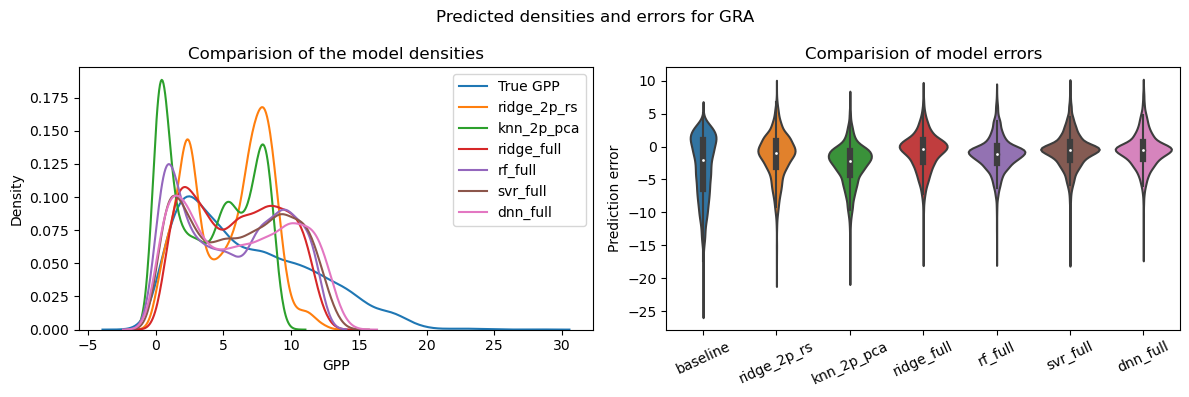

In [39]:
plot_desity_and_errors(df_pred_enf, df_err_enf, cover_type="ENF")
plot_desity_and_errors(df_pred_dbf, df_err_dbf, cover_type="DBF")
plot_desity_and_errors(df_pred_gra, df_err_gra, cover_type="GRA")

Looking at the predicted densities for the GRA site, it is clear the models generalize poorly with grassland ecosystems, which would probably deserve its own model.

### Timeline

We are now ready to plot the full timelines for the three sites.
We selected the random forest model `rf_full` as it performs well for all three sites although it is not the best performing.

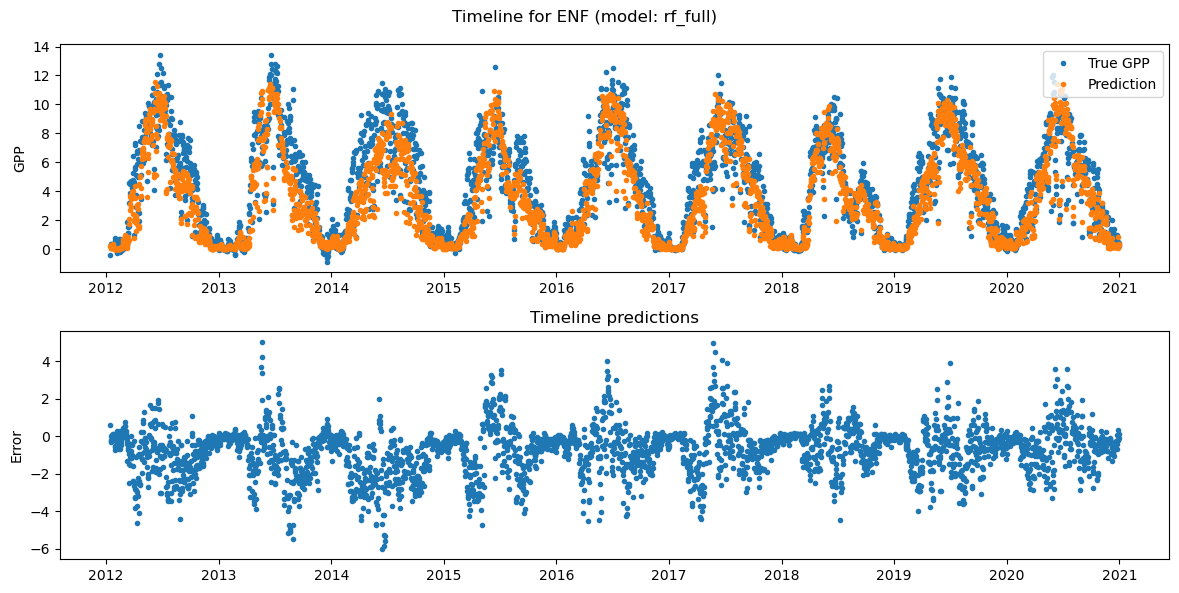

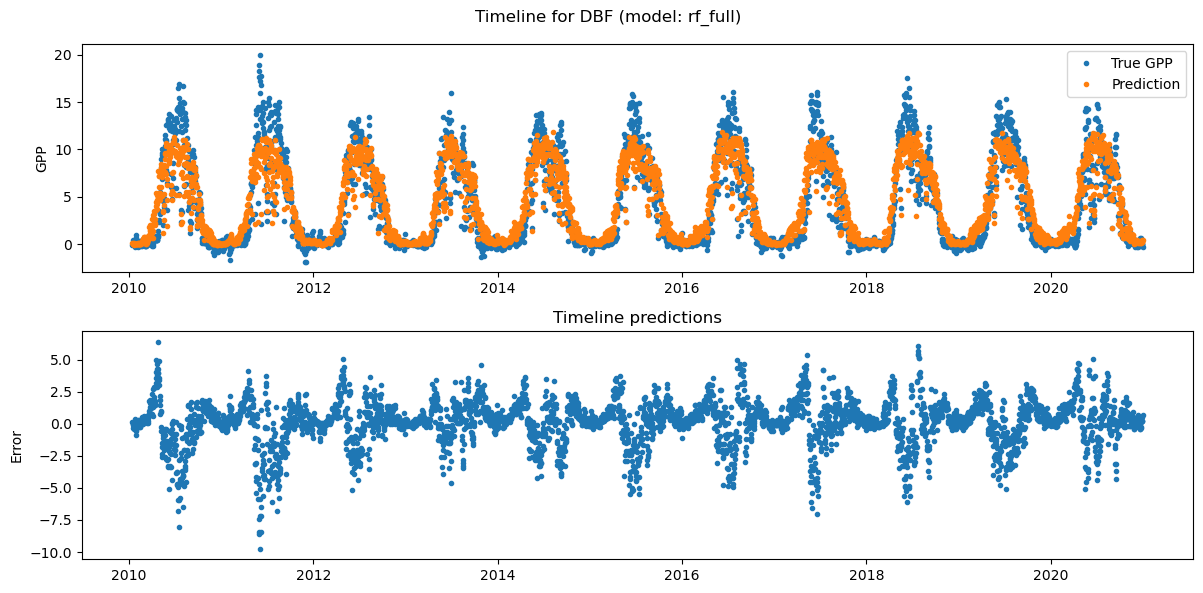

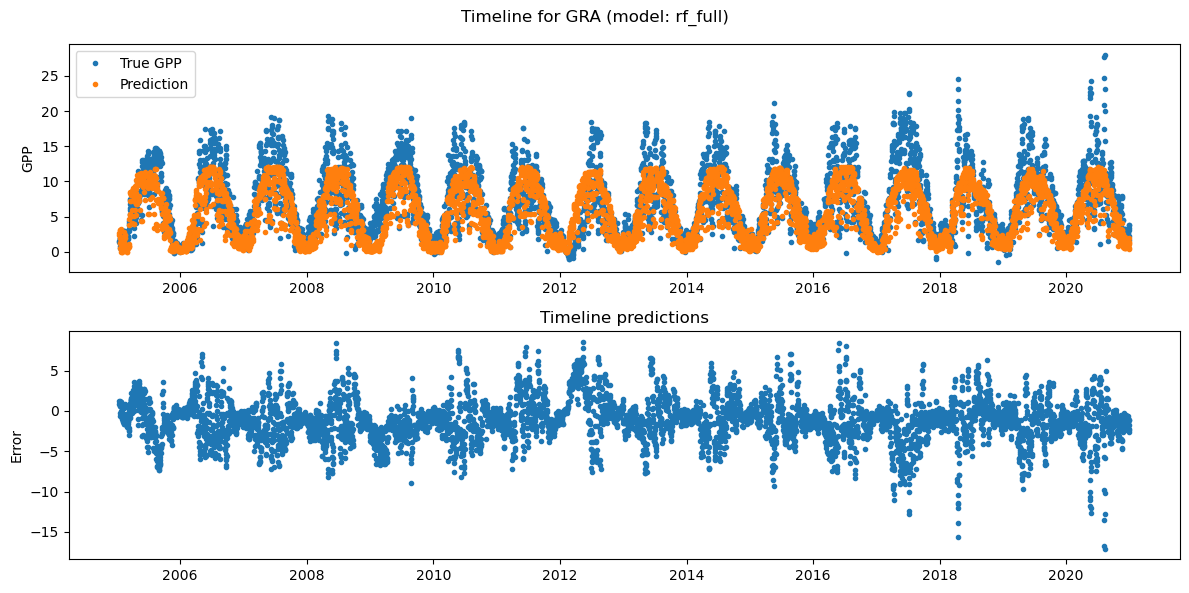

In [40]:
plot_timeline(df_pred_enf, df_err_enf, "rf_full", "ENF")
plot_timeline(df_pred_dbf, df_err_dbf, "rf_full", "DBF")
plot_timeline(df_pred_gra, df_err_gra, "rf_full", "GRA")

We can see that the model performs well on the ENF site, but is constantly underestimating for high GPP values for the two other sites.
It is also clear from these timelines that the estimation of GPP can be quite chaotic for high GPP values, likely due to the presence of noise.
This may explain that the models struggle there to model accurately these areas, but does not really explain the observed switch.

### Temporal generalization

Finally, let us end this analysis with the monthly and yearly error densities to see if we can identify some patterns.

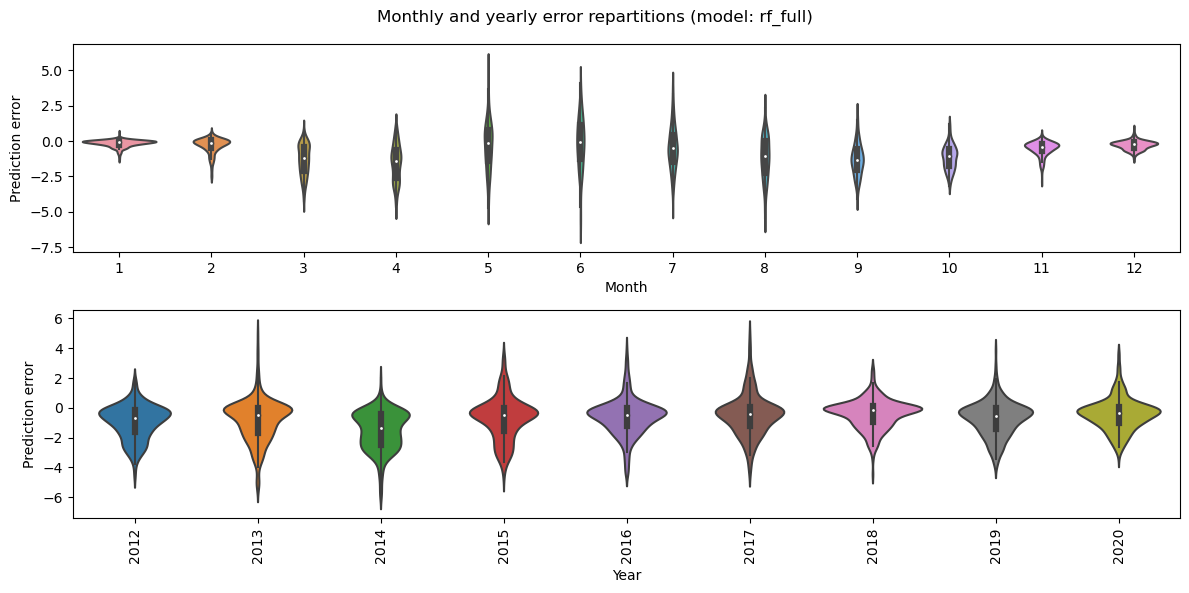

In [41]:
error_per_month_and_year(df_err_enf, "rf_full")

As previously observed, the winter months have a fairly compact error spread, while the variance in summer months is much greater.
The yearly densities show a somewhat regular shape with some variations, and a slightly upward trend bringing the prediction skew closer to zero.

## Discussion

### Results

We have shown that it is possible to model ecosystems' GPP from both meteorological, flux and remote sensed data.
The best models achieve an average absolute error under 1 GPP unit.

The models, which were trained on Evergreen Needleleaf Forest (ENF) data exclusively, performed well on unseen ENF data indicating a good cross-site generalization.
They also achieve a somewhat acceptable score on Deciduous Broadleaf Forest (DBF) data, but rather poorly on grassland data (GRA).
The sample size being one (time series), more testing would be required to draw a definite conclusion.

Noteworthy is the fact that a simple linear model only based on kilometric resolution remote sensed data achieved an average absolute error of 1.5 GPP unit.
This is encouraging and opens the door for more accurate models with future higher resolution imaging missions.

### Limits

As we have seen from the previous section, all the models suffer from a switch trend (overfitting low GPP values and underfitting high ones), as well as poor seasonal generalization.
This could be understandable with too simple models (such as `ridge_2p_rs`), but the fact that even non-linear models, such as random forests or DNN, do not manage to get rid of these issues is more concerning.
In this section we discuss the possible explanation for these results.

#### Methodology flaw

Firstly, the observed switch might indicate a methodology flaw. 
Here is a list of possible culprits:
- Forgetting to apply a reverse transform and other similar errors, although the use of Scikit pipelines should have protected us effectively against such mistakes.
- Issues during train/validate/test splitting. We used a shuffle splitting strategy and verified that the distributions of both training and test splits were comparable, so this is an unlikely issue as well.
- The fact that the distributions are heavily biased is also a concern, although the use of a quantile transform should have helped with this issue.

#### Noise

If some parameters can be measured with great accuracy (ex: temperature), it seems that GPP is more difficult to estimate.
The dataset contains two models of GPP (daytime and nighttime) and we used the mean of both to estimate GPP.
It is possible to assume that the data that is highly underestimated could actually be unusually high values caused by a noizy GPP estimator.
In this case, the tails we observe to the right of the scatter plots would essentially be outliers that the models did not to try to fit (thanks to the regularization).
We chose not to identify and discard any outliers during the EDA, but it might have helped to remove samples where the difference between the models was large (using a zscore threshold for instance).
Another idea could be to model separately both daytime and nighttime estimations and see if the models manage to fit one estimate better than the other.

#### Hidden variables

Another explanation could be that not all the necessary information for predicting GPP is present in the data at our disposal.
Some hidden variables could be:
- forest fires / floods
- human intervention (logging)
- diseases
- plant biology (hydric stress, plant "strategy", ...)
- site-dependent variables (geology, ...)

More domain expertise is needed to identify these and more work to include them into the models (such as a soil-water balance model for instance).

#### Time dependency

Another type of hidden variable is time.
Despite our best efforts to include sliding window variables to introduce some level of temporality in our models, it might not be sufficient.
For example, we saw that the random forest model did not put much emphasis on the amount of precipitation, although we expect this variable to play a crucial role in case of drought for instance.

More complex models capable of including temporal information, such as LTSM or CNN models, might be promising.